In [ ]:
import numpy as np
import pandas as pd

import torch
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F

from tqdm.notebook import tqdm

import io
import os
import copy

import requests
from google.colab import files

import zipfile
from PIL import Image

import matplotlib.pyplot as plt

from prettytable import PrettyTable

from IPython.display import display


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with zipfile.ZipFile("/content/drive/MyDrive/datasets/CelebA_masked_top4_Bcos_explanations.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [ ]:
root = '/content/data_faces/content/CelebA_eyes_masked'
img_list = os.listdir(root)

In [ ]:
import os

root = '/content/data_faces/content/CelebA_eyes_masked'

# List all files in the directory
img_list = os.listdir(root)

# Iterate through the files and rename them
for filename in img_list:
    if filename.startswith("result_"):
        new_filename = filename.replace("result_", "")
        os.rename(os.path.join(root, filename), os.path.join(root, new_filename))


img_list = os.listdir(root)

print("File names have been changed.")


File names have been changed.


In [ ]:
len(img_list)

202599

In [ ]:
img_list[0]

'178673.jpg'

In [ ]:
img_list.sort()

In [ ]:
img_list[0]

'000001.jpg'

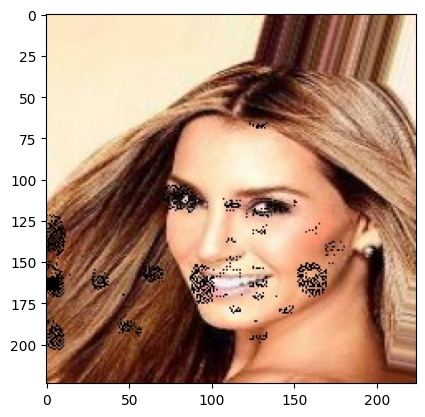

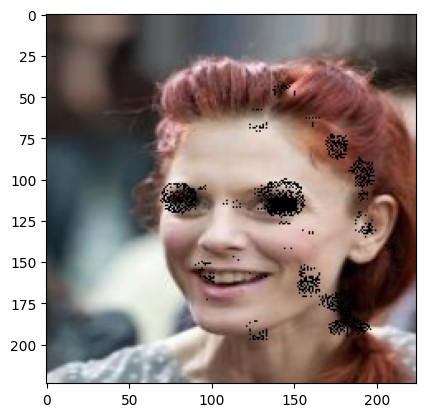

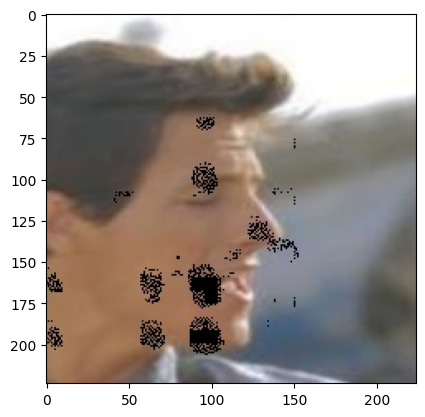

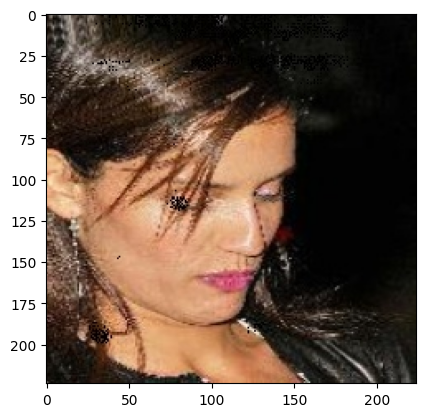

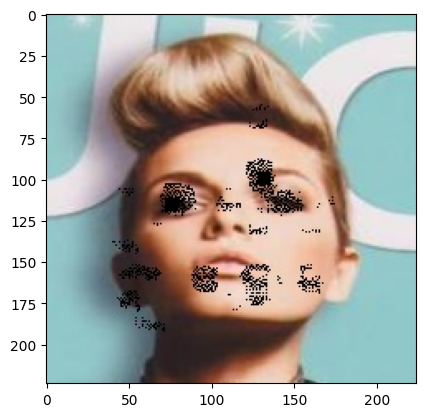

In [ ]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in range(5):

  img_path = os.path.join(root, img_list[i])

  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.show()



In [ ]:
uploaded = files.upload()

# Read the attribute dataset
df = pd.read_csv(io.BytesIO(uploaded['list_attr_celeba.csv']))
df.set_index('image_id', inplace=True)
df.replace(to_replace=-1, value=0, inplace=True) #-1 female to 0 female

# Read the partition dataset
df_partition = pd.read_csv(io.BytesIO(uploaded['list_eval_partition.csv']))
df_partition.set_index('image_id', inplace=True)

# Merge the gender attribute with the partition information
df_merged = df[['Male']].merge(df_partition['partition'], left_index=True, right_index=True)

# Save the merged dataset to a CSV file
df_merged.to_csv('celeba-gender-partitions.csv')

# Read the saved CSV file
df_final = pd.read_csv('celeba-gender-partitions.csv', index_col=0)
df_final.loc[df_final['partition'] == 0].to_csv('train_dataset.csv')
df_final.loc[df_final['partition'] == 1].to_csv('val_dataset.csv')
df_final.loc[df_final['partition'] == 2].to_csv('test_dataset.csv')

Saving list_eval_partition.csv to list_eval_partition.csv
Saving list_attr_celeba.csv to list_attr_celeba.csv


In [ ]:
df_final.head()

,Male,partition
image_id,,
000001.jpg,0,0
000002.jpg,0,0
000003.jpg,1,0
000004.jpg,0,0
000005.jpg,0,0


In [ ]:
### from b-cos
from torch import Tensor

class AddInverse(torch.nn.Module):
    """To a [B, C, H, W] input add the inverse channels of the given one to it.
    Results in a [B, 2C, H, W] output. Single image [C, H, W] is also accepted.

    Args:
        dim (int): where to add channels to. Default: -3
    """

    def __init__(self, dim: int = -3):
        super().__init__()
        self.dim = dim

    def forward(self, in_tensor: Tensor) -> Tensor:
        return torch.cat([in_tensor, 1 - in_tensor], dim=self.dim)

In [ ]:
class CelebaDataset(Dataset):
    """Custom Dataset for loading CelebA face images"""

    def __init__(self, csv_path, img_dir, transform=None):

        df = pd.read_csv(csv_path, index_col=0)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df.index.values
        self.y = df['Male'].values
        self.transform = transform


    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))



        if self.transform is not None:
            img = self.transform(img)

        label = self.y[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [ ]:
# transformations for the dataset
custom_transform = transforms.Compose([
                                       transforms.ToTensor(),
                                       AddInverse()]) #from b-cos github


In [ ]:
# splitting into training, validating and testing datasets

train_dataset = CelebaDataset(csv_path='train_dataset.csv',
                              img_dir= root,
                              transform=custom_transform)

valid_dataset = CelebaDataset(csv_path='val_dataset.csv',
                              img_dir= root,
                              transform=custom_transform)

test_dataset = CelebaDataset(csv_path='test_dataset.csv',
                             img_dir= root,
                             transform=custom_transform)

In [ ]:
batch_size = 64
# Create data loaders

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=4)

valid_loader = DataLoader(dataset=valid_dataset,
                          batch_size=batch_size,
                          shuffle=False,
                          num_workers=4)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=False,
                         num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# for later usage of model.explain() method tensors must be of size [6,224,224]

# Get the first sample
sample = test_dataset[0]
image_tensor, label = sample

# size of the image tensor
image_tensor.shape


torch.Size([6, 224, 224])

In [ ]:
unique_labels = np.unique(test_dataset.y)
class_label_to_index = {label: idx for idx, label in enumerate(unique_labels)}


In [ ]:
!pip install bcos

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 2.1 MB/s eta 0:00:00


In [ ]:
"""
B-cos ResNet/ResNeXt/Wide-ResNet models

Modified from https://github.com/pytorch/vision/blob/0504df5ddf9431909130e7788faf05446bb8a2/torchvision/models/resnet.py

CIFAR10 modifications from
https://github.com/chenyaofo/pytorch-cifar-models/blob/e9482ebc665084761ad9c84d36c83cbb82/pytorch_cifar_models/resnet.py
"""
import math
from typing import Any, Callable, List, Optional, Type, Union

import torch.nn as nn
from torchvision.ops import StochasticDepth

from bcos.common import BcosUtilMixin
from bcos.modules import BcosConv2d, LogitLayer, norms

__all__ = [
    "BcosResNet",
    "resnet18",
    "resnet34",
    "resnet50",
    "resnet101",
    "resnet152",
    "resnext50_32x4d",
    "resnext101_32x8d",
    "wide_resnet50_2",
    "wide_resnet101_2",
    # cifar
    "cifar10_resnet20",
    "cifar10_resnet32",
    "cifar10_resnet44",
    "cifar10_resnet56",
    "cifar10_resnet110",
    "cifar10_resnext29_8x64d",
    "cifar10_resnext29_16x64d",
    "cifar10_resnext29_32x4d",
    "cifar10_resnext29_16x8d",
    "cifar10_resnext47_16x8d",
    "cifar10_resnext47_32x4d",
    "cifar10_resnext65_16x8d",
    "cifar10_resnext65_32x4d",
    "cifar10_resnext101_16x8d",
    "cifar10_resnext101_32x4d",
]


DEFAULT_NORM_LAYER = norms.NoBias(norms.DetachablePositionNorm2d)
DEFAULT_CONV_LAYER = BcosConv2d


def conv3x3(
    in_planes: int,
    out_planes: int,
    stride: int = 1,
    groups: int = 1,
    dilation: int = 1,
    conv_layer: Callable[..., nn.Module] = DEFAULT_CONV_LAYER,
):
    """3x3 convolution with padding"""
    return conv_layer(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(
    in_planes: int,
    out_planes: int,
    stride: int = 1,
    conv_layer: Callable[..., nn.Module] = DEFAULT_CONV_LAYER,
):
    """1x1 convolution"""
    return conv_layer(
        in_planes,
        out_planes,
        kernel_size=1,
        stride=stride,
        bias=False,
    )


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = DEFAULT_NORM_LAYER,
        conv_layer: Callable[..., nn.Module] = DEFAULT_CONV_LAYER,
        # act_layer: Callable[..., nn.Module] = None,
        stochastic_depth_prob: float = 0.0,
    ):
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.Identity
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(
            inplanes,
            planes,
            stride,
            conv_layer=conv_layer,
        )
        self.bn1 = norm_layer(planes)
        # self.act = act_layer(inplace=True)
        self.conv2 = conv3x3(
            planes,
            planes,
            conv_layer=conv_layer,
        )
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride
        self.stochastic_depth = (
            StochasticDepth(stochastic_depth_prob, "row")
            if stochastic_depth_prob
            else None
        )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        # out = self.act(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.stochastic_depth is not None:
            out = self.stochastic_depth(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        # out = self.act(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = DEFAULT_NORM_LAYER,
        conv_layer: Callable[..., nn.Module] = DEFAULT_CONV_LAYER,
        # act_layer: Callable[..., nn.Module] = None,
        stochastic_depth_prob: float = 0.0,
    ) -> None:
        super(Bottleneck, self).__init__()
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(
            inplanes,
            width,
            conv_layer=conv_layer,
        )
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(
            width,
            width,
            stride,
            groups,
            dilation,
            conv_layer=conv_layer,
        )
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(
            width,
            planes * self.expansion,
            conv_layer=conv_layer,
        )
        self.bn3 = norm_layer(planes * self.expansion)
        # self.act = act_layer(inplace=True)
        self.downsample = downsample
        self.stride = stride
        self.stochastic_depth = (
            StochasticDepth(stochastic_depth_prob, "row")
            if stochastic_depth_prob
            else None
        )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        # out = self.act(out)

        out = self.conv2(out)
        out = self.bn2(out)
        # out = self.act(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.stochastic_depth is not None:
            out = self.stochastic_depth(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        # out = self.act(out)

        return out


class BcosResNet(BcosUtilMixin, nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        in_chans: int = 6,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = DEFAULT_NORM_LAYER,
        conv_layer: Callable[..., nn.Module] = DEFAULT_CONV_LAYER,
        # act_layer: Callable[..., nn.Module] = None,
        inplanes: int = 64,
        small_inputs: bool = False,
        stochastic_depth_prob: float = 0.0,
        logit_bias: Optional[float] = None,
        logit_temperature: Optional[float] = None,
        **kwargs: Any,  # ignore rest
    ):
        super().__init__()

        if kwargs:
            print("The following args passed to model will be ignored", kwargs)

        if norm_layer is None:
            norm_layer = nn.Identity
        self._norm_layer = norm_layer
        self._conv_layer = conv_layer
        # self._act_layer = act_layer

        self.inplanes = inplanes
        self.dilation = 1
        n = len(layers)  # number of stages
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False] * (n - 1)
        if len(replace_stride_with_dilation) != n - 1:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a {n - 1}-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group

        if small_inputs:
            self.conv1 = conv3x3(
                in_chans,
                self.inplanes,
                conv_layer=conv_layer,
            )
            self.pool = None
        else:
            self.conv1 = conv_layer(
                in_chans,
                self.inplanes,
                kernel_size=7,
                stride=2,
                padding=3,
            )
            self.pool = nn.AvgPool2d(kernel_size=3, stride=2, padding=1)

        self.bn1 = norm_layer(self.inplanes)
        # self.act = act_layer(inplace=True)

        self.__total_num_blocks = sum(layers)
        self.__num_blocks = 0
        self.layer1 = self._make_layer(
            block,
            inplanes,
            layers[0],
            stochastic_depth_prob=stochastic_depth_prob,
        )
        self.layer2 = self._make_layer(
            block,
            inplanes * 2,
            layers[1],
            stride=2,
            dilate=replace_stride_with_dilation[0],
            stochastic_depth_prob=stochastic_depth_prob,
        )
        self.layer3 = self._make_layer(
            block,
            inplanes * 4,
            layers[2],
            stride=2,
            dilate=replace_stride_with_dilation[1],
            stochastic_depth_prob=stochastic_depth_prob,
        )
        try:
            self.layer4 = self._make_layer(
                block,
                inplanes * 8,
                layers[3],
                stride=2,
                dilate=replace_stride_with_dilation[2],
                stochastic_depth_prob=stochastic_depth_prob,
            )
            last_ch = inplanes * 8
        except IndexError:
            self.layer4 = None
            last_ch = inplanes * 4

        self.num_features = last_ch * block.expansion
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        self.num_classes = num_classes
        self.fc = conv_layer(
            self.num_features,
            self.num_classes,
            kernel_size=1,
        )
        self.logit_layer = LogitLayer(
            logit_temperature=logit_temperature,
            logit_bias=logit_bias or -math.log(num_classes - 1),
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                if m.weight is not None:
                    nn.init.constant_(m.weight, 1)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
        stochastic_depth_prob: float = 0.0,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        conv_layer = self._conv_layer
        # act_layer = self._act_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(
                    self.inplanes,
                    planes * block.expansion,
                    stride,
                    conv_layer=conv_layer,
                ),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes,
                planes,
                stride,
                downsample,
                self.groups,
                self.base_width,
                previous_dilation,
                norm_layer=norm_layer,
                conv_layer=conv_layer,
                # act_layer=act_layer,
                stochastic_depth_prob=stochastic_depth_prob
                * self.__num_blocks
                / (self.__total_num_blocks - 1),
            )
        )
        self.__num_blocks += 1
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                    conv_layer=conv_layer,
                    # act_layer=act_layer,
                    stochastic_depth_prob=stochastic_depth_prob
                    * self.__num_blocks
                    / (self.__total_num_blocks - 1),
                )
            )
            self.__num_blocks += 1

        return nn.Sequential(*layers)

    def forward_features(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        # x = self.act(x)
        if self.pool is not None:
            x = self.pool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        if self.layer4 is not None:
            x = self.layer4(x)
        return x

    def forward(self, x):
        x = self.forward_features(x)

        x = self.fc(x)
        x = self.avgpool(x)
        x = x.flatten(1)
        x = self.logit_layer(x)

        return x

    def get_classifier(self) -> nn.Module:
        """Returns the classifier part of the model. Note this comes before global pooling."""
        return self.fc

    def get_feature_extractor(self) -> nn.Module:
        """Returns the feature extractor part of the model. Without global pooling."""
        modules = [
            self.conv1,
            self.bn1,
            # self.act,
        ]
        if self.pool is not None:
            modules += [self.pool]
        modules += [
            self.layer1,
            self.layer2,
            self.layer3,
        ]
        if self.layer4 is not None:
            modules += [self.layer4]
        return nn.Sequential(*modules)


def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    pretrained: bool = False,
    progress: bool = True,
    inplanes: int = 64,
    **kwargs: Any,
) -> BcosResNet:
    model = BcosResNet(block, layers, inplanes=inplanes, **kwargs)
    if pretrained:
        raise ValueError(
            "If you want to load pretrained weights, then please use the entrypoints in "
            "bcos.pretrained or bcos.model.pretrained instead."
        )
    return model


###############################   ResNet for CelebA   ###########################################
def _update_if_not_present(key, value, d):
    if key not in d:
        d[key] = value


def _update_default_celeba(kwargs) -> None:
    _update_if_not_present("num_classes", 2, kwargs)


def Celeba_without_top4expl_resnet18(
    pretrained: bool = False, progress: bool = True, **kwargs
) -> BcosResNet:
    """Constructs a CelebA ResNet-18 model."""
    _update_default_celeba(kwargs)
    model = _resnet("Celeba_without_top4expl_resnet18", BasicBlock, [2, 2, 2, 2], pretrained, progress, **kwargs)
    return model
#################################################################################################






In [ ]:
num_epochs = 4
lr_start = 0.01
lr_end = 1e-3

# GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device.type}")

# B-cos ResNet-18 model
model = Celeba_without_top4expl_resnet18(in_chans = 6, num_classes = 2)
model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr_start)


alpha = (lr_end / lr_start) ** (1.0 / (num_epochs - 1))
lmbda = lambda epoch: alpha**epoch
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lmbda)

lrs = []
loss_train_perBatch = []
loss_train = []
loss_test = []
df = pd.DataFrame(columns=["epoch"])

epoch = 0
epoch_bar = tqdm(range(num_epochs))
for epoch in epoch_bar:


    ############
    # training #
    ############
    model.train()

    pbar = tqdm(train_loader, total=len(train_loader), desc="", leave=False)
    for data in pbar:
        images, targets = data[0].to(device), data[1].to(device)
        #         print(images.shape, targets.shape, targets)
        #         break

        optimizer.zero_grad()

        outputs = model(images)

        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        pbar.set_description(f"Loss: {loss.item():.5f}")
        loss_train_perBatch.append(loss.item())
    #     break

    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()

    ##############
    # validation #
    ##############
    model.eval()

    correct = 0
    total = 0
    num_batch = 0

    correct_pred = {idx: 0 for name, idx in class_label_to_index.items()}
    total_pred = {idx: 0 for name, idx in class_label_to_index.items()}

    loss_test.append(0.0)
    with torch.no_grad():
        for data in tqdm(test_loader, total=len(test_loader), desc="Test", leave=False):
            images, targets = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss_test[-1] += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            for y, pred in zip(targets, predicted):
                y = y.item()
                pred = pred.cpu().item()
                if y == pred:
                    correct_pred[y] += 1
                total_pred[y] += 1
            total += targets.size(0)
            correct += (predicted.cpu() == targets.cpu()).sum().item()
            num_batch += 1

    loss_test[-1] /= num_batch
    logger = {"epoch": epoch + 1, "acc_test": correct / total}

    correct, total, num_batch = 0, 0, 0
    loss_train.append(0)
    with torch.no_grad():
        for data in tqdm(train_loader, total=len(train_loader), desc="", leave=False):
            images, targets = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, targets)
            loss_train[-1] += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted.cpu() == targets.cpu()).sum().item()
            num_batch += 1
    loss_train[-1] /= num_batch
    logger["acc_train"] = correct / total

    for key, val in correct_pred.items():
        logger[f"acc_c{key}"] = val / total_pred[key]

    df = df.append(logger, ignore_index=True)
    epoch_bar.set_description(
        f"lr: {lrs[-1]:.4g}, "
        + ", ".join(
            f"{key}: {logger[key]:.2f}"
            for key, val in logger.items()
            if key in ["acc_test", "acc_train"]
        )
    )

print("Finished training")

model_save_name = 'Bcos_ResNet18_CelebA_without_top4_explanations.pth'
path = F"/content/drive/MyDrive/{model_save_name}"
torch.save(model.state_dict(), path)


scores = df.to_dict("list")
scores["loss_train"] = loss_train
scores["loss_test"] = loss_test
scores["loss_train_perBatch"] = loss_train_perBatch
scores["lr"] = lrs

scores_cnn = scores



device: cuda


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/2544 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test:   0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/2544 [00:00<?, ?it/s]

<ipython-input-44-e28ddff266ba>:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(logger, ignore_index=True)


  0%|          | 0/2544 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test:   0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/2544 [00:00<?, ?it/s]

<ipython-input-44-e28ddff266ba>:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(logger, ignore_index=True)


  0%|          | 0/2544 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test:   0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/2544 [00:00<?, ?it/s]

<ipython-input-44-e28ddff266ba>:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(logger, ignore_index=True)


  0%|          | 0/2544 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test:   0%|          | 0/312 [00:00<?, ?it/s]

  0%|          | 0/2544 [00:00<?, ?it/s]

<ipython-input-44-e28ddff266ba>:112: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(logger, ignore_index=True)


Finished training


In [ ]:
import matplotlib.pyplot as plt

# B-cos ResNet-18 model
model = Celeba_without_top4expl_resnet18(in_chans = 6, num_classes = 2)
model_save_name = 'Bcos_ResNet18_CelebA_without_top4_explanations.pth'
path = F"/content/drive/MyDrive/{model_save_name}"

model.load_state_dict(torch.load(path))

num_images_to_display = 14


fig, axs = plt.subplots(num_images_to_display, 2, figsize=(5, 3 * num_images_to_display))

for i, image_number in enumerate(range(num_images_to_display)):

    for batch_idx, (features, targets) in enumerate(test_loader):
        if batch_idx >= image_number + 1:
            break

    # Display the original image (remove the added inverse channels)
    original_image = features[image_number, :3].cpu().numpy()  # Keep only the original 3 channels
    axs[i, 0].imshow(np.transpose(original_image, (1, 2, 0)))
    axs[i, 0].axis('off')
    axs[i, 0].set_title("Original Image")

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)

    model.eval()

    # forward pass and class probabilities
    with torch.no_grad():
        logits = model(features.to(device)[image_number, None])
        probas = torch.softmax(logits, dim=1)

    # get the predicted class index (0 for Female, 1 for Male)
    predicted_class = torch.argmax(probas, dim=1)

    # get the probability associated with the predicted class
    probability = probas[0][predicted_class.item()].item()

    predicted_class_label = predicted_class.item()
    prob_percentage = probability * 100
    prediction_str = f"Predicted class: {predicted_class_label}\nProbability: {prob_percentage:.2f}%"
    axs[i, 0].text(0.5, -0.15, prediction_str, size=10, ha="center", transform=axs[i, 0].transAxes)

    img = features[image_number].to(device)
    img = img[None]  # add batch dim

    model.eval()
    expl_out = model.explain(img)

    axs[i, 1].imshow(expl_out["explanation"])
    axs[i, 1].axis('off')
    axs[i, 1].set_title("Explanation")

plt.tight_layout()
plt.show()




Output hidden; open in https://colab.research.google.com to view.